In [1]:
import random
import time
from collections import namedtuple
import copy
import tqdm
import gymnasium as gym

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math 
import torch.nn.functional as F
%matplotlib inline

In [2]:
env = gym.make(
    'FrozenLake-v1',
    desc=None,
    map_name="4x4",
    is_slippery=False,
    # success_rate=1.0/3.0,
    reward_schedule=(1, 0, 0)
)
env_vis = gym.make(
    'FrozenLake-v1',
    desc=None,
    map_name="4x4",
    is_slippery=False,
    # success_rate=1.0/3.0,
    reward_schedule=(1, 0, 0),
    render_mode="rgb_array"
)

In [3]:
env.observation_space.n

np.int64(16)

In [4]:
env.action_space.n

np.int64(4)

In [5]:
class ExponentialSchedule:
    def __init__(self, initial_value, final_value, num_steps):
        """
        Exponential schedule from initial_value to final_value in num_steps.
        $ value(t) = a * exp(b*t) $
        Determines the probability with which we will choose a random action. 
        This value is high initially to encourage exploration, and is gradually reduced as we approach optimal Q-values.
        """
        self.initial_value = initial_value
        self.final_value = final_value
        self.num_steps = num_steps

        self.a = initial_value
        self.b = np.log(self.final_value/self.initial_value) / (self.num_steps - 1)

    def value(self, step) -> float: 
        if step<=0:
            return self.initial_value
        elif step >= self.num_steps:
            return self.final_value
        return self.a * np.exp(step * self.b)

In [6]:
def to_one_hot(state, n_dim):
    # if isinstance(state, torch.Tensor):
    #     state = state.item()
    vec = np.zeros(n_dim, dtype=np.float32)
    vec[state] = 1.0
    return vec

In [7]:
Batch = namedtuple('Batch', ('states', 'actions', 'rewards', 'next_states', 'dones'))

class ReplayMemory:
    def __init__(self, max_size, state_size):
        """
        Replay memory implemented as a circular buffer.
        Experiences will be removed in a FIFO manner on reaching max_size.
        Args:
            - max_size: Maximum size of the buffer
            - state_size: size of state-space features for the env
        """
        self.max_size = max_size
        self.state_size = state_size
        self.size = 0 # current buffer size

        # Preallocating memory for speed
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype = torch.long)
        self.rewards = torch.empty((max_size,1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # pointer to current location in the circular buffer
        self.idx = 0

        # number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer.
        Args:
            - state: 1-D np.ndarray of size state_size consisting of state features 
            - action: integer action
            - reward: float reward
            - next_state: 1D np.ndarray of state-features
            - done: boolean value indicating end of epiosde (terminated/truncated)
        """
        # store transitions (convert from numpy arrays to tensors)
        self.states[self.idx] = torch.tensor(state, dtype=torch.float32)
        self.actions[self.idx] = torch.tensor(action, dtype=torch.float32)
        self.rewards[self.idx] = torch.tensor(reward, dtype=torch.float32)
        self.next_states[self.idx] = torch.tensor(next_state, dtype=torch.float32)
        self.dones[self.idx] = torch.tensor(done, dtype=torch.float32)

        # update current pointer
        self.idx = (self.idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """
        Sample a batch of experiences.
        If the buffer contains less than 'batch_size' transitions, sample all of them.
        Args:
            - batch_size: Number of transitions to sample
        Returns:
            - a batch of experiences of type 'Batch'
        """
        # number of samples to pick
        effective_batch_size = min(batch_size, self.size)

        sample_indices = np.random.choice(self.size, effective_batch_size, replace=False)
        # sample indices can range from 0 to self.size, sample size should be 'effective_batch_size'
        
        batch = Batch(states = self.states[sample_indices],
                      actions = self.actions[sample_indices],
                      rewards = self.rewards[sample_indices],
                      next_states = self.next_states[sample_indices],
                      dones = self.dones[sample_indices])
        return batch
        
        
    def populate(self, env, num_steps):
        """
        Populates replay memory with 'num_steps' from random policy.
        """
        state, info = env.reset()
        state = to_one_hot(state, n_dim=16)
        for i in range(num_steps):
            action = env.action_space.sample()
            # action = to_one_hot(action, n_dim=4)
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state = to_one_hot(next_state, n_dim=16)
            done = terminated or truncated
            self.add(state, action, reward, next_state, done)

            if done:
                state, info = env.reset()
            else:
                state = next_state        
                   

In [8]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=128):
        super().__init__()
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        
        self.layer1 = nn.Linear(state_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, action_dim)

    
    def forward(self, x) -> torch.Tensor:
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }
    
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model
    

In [9]:
class ICM(nn.Module):
    def __init__(self, input_dims=16, act_dims=1, hidden_dims=128, alpha=0.5, beta=0.2):
        super(ICM, self).__init__()
        self.alpha = alpha
        self.beta = beta
        
        self.inverse_model = nn.Sequential(
            nn.Linear(input_dims*2, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, act_dims)
        )

        self.forward_model = nn.Sequential(
            nn.Linear(input_dims + act_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, input_dims)
        )

    def forward(self, state, next_state, action):
        # print("state: ", state.shape, "next_state: ", next_state.shape, "action: ", action.shape)
        inv_input = torch.cat([state, next_state], dim=1)
        action_pred = self.inverse_model(inv_input)
        fwd_input = torch.cat([state, action], dim=1)
        next_state_pred = self.forward_model(fwd_input)
        # ri = self.alpha * ((state - new_state).pow(2)).mean(dim=1)
        return action_pred, next_state_pred

In [10]:
# def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
#     """Performs a single batch update step on given dqn_model.
#     Args:
#         - optimizer: nn.optim.Optimizer instance
#         - batch: Batch of experiences (type Batch)
#         - dqn_model: DQN model to be trained
#         - gamma: discount factor
#     rtpe: Float. scalar loss for this batch
#     """
#     values = dqn_model(batch.states).gather(1, batch.actions)
#     with torch.no_grad():
#         next_q_values = dqn_target(batch.next_states).max(1, keepdim=True)[0]
#         target_values = batch.rewards + gamma *next_q_values * (~batch.dones)

#     # Tests
#     assert (values.shape == target_values.shape), 'Shapes of values tensor and target values tensor do not match.'
#     assert (values.requires_grad), 'values tensor requires gradients.'
#     assert (not target_values.requires_grad), 'target_values tensor should not require gradients.'

#     loss = F.mse_loss(values, target_values)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     return loss.item()

In [47]:
def train_dqn(env, num_steps, *, num_saves = 5, replay_size, 
              replay_prepopulate_steps=0, batch_size, exploration, gamma, alpha=0.5, beta=0.3):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes. The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The Gymnasium environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: An ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # Check that env states are compatible with our DQN representation
    # assert (isinstance(env.observation_space, gym.spaces.Discrete) and env.observation_space.n == 16)

    state_size = env.observation_space.n
    action_size = env.action_space.n
    # state_size = 16
    
    dqn_model = DQN(state_size, action_size)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())
    icm = ICM(state_size,4)

    lr = 0.001
    opt_dqn = torch.optim.Adam(dqn_model.parameters())
    opt_icm = torch.optim.Adam(icm.parameters())
    

    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    rewards = []
    returns = []
    lengths = []
    losses_dqn = []
    losses_icm = []

    # Initialize structures to save models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves-1, endpoint=False)
    saved_models = {}
    i_episode = 0 # index of current episode
    t_episode = 0 # time-step inside current episode

    state, _ = env.reset()
    state = to_one_hot(state, state_size)
    G = 0

    # Iterate for a total of 'num_steps' steps
    pbar = tqdm.trange(num_steps)
    for t_total in pbar:
        # t_total: time-step from the beginning of training 
        if t_total in t_saves:
            model_name = f'{100*t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        eps_value = exploration.value(t_total)
        if np.random.rand() < eps_value:
            action = env.action_space.sample()
            # action = to_one_hot(action, n_dim=4)
        else:
            # print(state)
            action = dqn_model(torch.tensor(state, dtype=torch.float32)).argmax().item()
        next_state, reward, done, trunc, _ = env.step(action)
        next_state = to_one_hot(next_state, state_size)
        memory.add(state, action, reward, next_state, done)
        state = next_state
        G += reward
        t_episode += 1

        # Once every 4 steps, sample a batch from replay memory and perform a batch update
        if t_total%4 == 0:
            batch = memory.sample(batch_size)
            batch_actions = F.one_hot(batch.actions.squeeze(-1), num_classes=4).float()
            # print(batch.states.shape, batch.next_states.shape, batch_actions.shape)
            actions_pred, next_states_pred = icm(batch.states, batch.next_states, batch_actions)
            # print(actions_pred, next_states_pred)
            rewards_int = 0.5 * F.mse_loss(batch.next_states, next_states_pred)
            # rewards_total = (1-alpha) * batch.rewards + alpha * rewards_int.detach()
            rewards_total = batch.rewards + rewards_int.detach()

            # Update DQN
            values = dqn_model(batch.states).gather(1, batch.actions)
            with torch.no_grad():
                next_q_values = dqn_target(batch.next_states).max(1, keepdim=True)[0]
                target_values = rewards_total + gamma *next_q_values * (~batch.dones)
                
            loss_dqn = F.mse_loss(values, target_values)
            opt_dqn.zero_grad()
            loss_dqn.backward()
            opt_dqn.step()

            # Update ICM 
            # print(actions_pred.shape, batch.actions.shape)
            # action_dim = 4
            # actions_onehot = F.one_hot(batch.actions.squeeze(-1), num_classes=action_dim).float()
            
            loss_inv = F.cross_entropy(actions_pred, batch.actions.squeeze(-1))
            loss_fwd = F.mse_loss(next_states_pred, batch.next_states)
            loss_icm = (1 - beta) * loss_inv + beta * loss_fwd
            opt_icm.zero_grad()
            loss_icm.backward()
            opt_icm.step()

            losses_dqn.append(loss_dqn.detach().item())
            losses_icm.append(loss_icm.detach().item())

        # update target network every 10k steps
        if t_total % 1_000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done or trunc:
            returns.append(G)
            rewards.append(reward)
            lengths.append(t_episode)
            pbar.set_description(f'Episode: {i_episode} | Steps: {t_episode+1} | Return : {G:5.2f} | Epsilon: {eps_value:4.2f}')
            state, _ = env.reset()
            state = to_one_hot(state, state_size)
            G = 0
            t_episode = 0
            i_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)
    return (saved_models, np.array(returns), np.array(lengths), np.array(losses_dqn), np.array(losses_icm))

In [48]:
def moving_average(data, *, window_size=50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(np.ones_like(data), kernel)
    return smooth_data[: -window_size+1]

In [54]:
# Values for debugging, change all values later
gamma = 0.99
num_steps = 15_000
num_saves = 25
replay_size = 2_000
replay_prepopulate_steps = 500
batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000)

dqn_models, returns, lengths, losses_dqn, losses_icm = train_dqn(
    env, num_steps,
    num_saves = num_saves,
    replay_size = replay_size,
    replay_prepopulate_steps = replay_prepopulate_steps,
    batch_size = batch_size,
    exploration = exploration,
    gamma = gamma)

# print(len(dqn_models))
assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')    


Episode: 1705 | Steps: 7 | Return :  1.00 | Epsilon: 0.05: 100%|█| 15000/15000 [


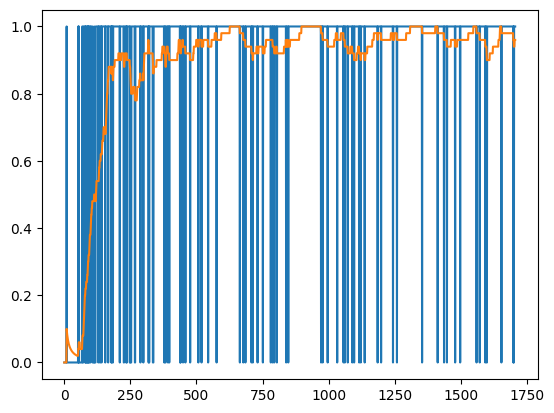

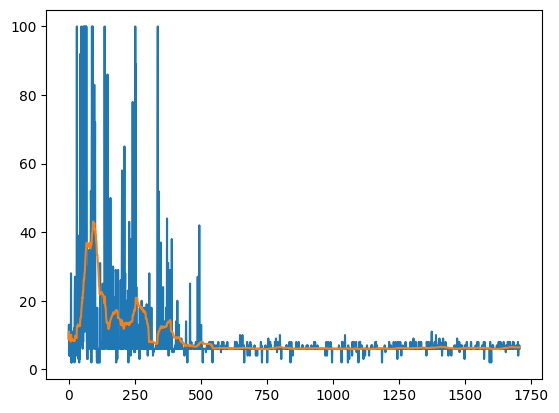

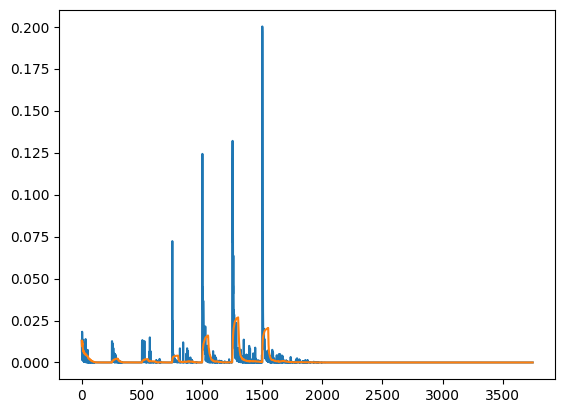

In [55]:
plt.plot(returns)
plt.plot(moving_average(returns))
plt.show()
plt.plot(lengths)
plt.plot(moving_average(lengths))
plt.show()
plt.plot(losses_dqn)
plt.plot(moving_average(losses_dqn))
plt.show()